In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
data = pd.read_excel('cross.xlsx', header = None)
data

0  1         2         3
0    1945  9  0.818149  0.000346
1    1537  7  0.149865  0.679496
2       1  1  1.000000  1.000000
3    2151  5  0.453798  0.953450
4     846  3  0.083470  0.427061
..    ... ..       ...       ...
495  2420  9  0.968778  0.000302
496  1453  5  0.646346  0.000408
497   813  2  0.911890 -0.412293
498   619  6  0.471568  0.709351
499     1  1  1.000000  1.000000

[500 rows x 4 columns]

In [3]:
data = data[data[3]<1]
data = data[data[3]>0]
data

0   1         2         3
0    1945   9  0.818149  0.000346
1    1537   7  0.149865  0.679496
3    2151   5  0.453798  0.953450
4     846   3  0.083470  0.427061
6    1554   5  0.060471  0.610700
..    ...  ..       ...       ...
490  1445   2  0.382938  0.787198
491  1611  10  0.333373  0.889115
495  2420   9  0.968778  0.000302
496  1453   5  0.646346  0.000408
498   619   6  0.471568  0.709351

[374 rows x 4 columns]

In [4]:
index = np.arange(1, data.shape[0]+1)
data.set_index(pd.Series(index), inplace=True)
data

0   1         2         3
1    1945   9  0.818149  0.000346
2    1537   7  0.149865  0.679496
3    2151   5  0.453798  0.953450
4     846   3  0.083470  0.427061
5    1554   5  0.060471  0.610700
..    ...  ..       ...       ...
370  1445   2  0.382938  0.787198
371  1611  10  0.333373  0.889115
372  2420   9  0.968778  0.000302
373  1453   5  0.646346  0.000408
374   619   6  0.471568  0.709351

[374 rows x 4 columns]

In [5]:
dataset = data.to_numpy()
dataset

array([[1.94500000e+03, 9.00000000e+00, 8.18148554e-01, 3.46191906e-04],
       [1.53700000e+03, 7.00000000e+00, 1.49865442e-01, 6.79495614e-01],
       [2.15100000e+03, 5.00000000e+00, 4.53797709e-01, 9.53449643e-01],
       ...,
       [2.42000000e+03, 9.00000000e+00, 9.68777663e-01, 3.02032588e-04],
       [1.45300000e+03, 5.00000000e+00, 6.46346065e-01, 4.08460089e-04],
       [6.19000000e+02, 6.00000000e+00, 4.71567877e-01, 7.09351059e-01]])

In [6]:
dataset[:,3] = dataset[:,3]*100

In [7]:
def to_XY(dataset):
    x = dataset[:,0:3]
    y = dataset[:,3]

    return np.array(x),np.array(y)

In [8]:
def get_model(num_layers, acti_fun):
    model = Sequential()
    num_neurons = np.random.randint(2, 10, size = num_layers)
    for i in range(num_layers):
        model.add(Dense(num_neurons[i], activation=acti_fun))
    model.add(Dense(1))
    opt = keras.optimizers.Adadelta(learning_rate=0.1)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics= ['accuracy'])
    return model

def evaluate_model(model, trainX, trainY, testX, testY):
    model.fit(trainX, trainY, batch_size=50, verbose = 0, epochs = 15, validation_data= (testX, testY))
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    ##print('Train Score: {} RMSE'.format(trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    ##print('Test Score: {} RMSE'.format(testScore))
    return trainScore, testScore
    

In [10]:
num_layers = np.random.randint(1, high = 5, size = 5)
activation_fun = ['relu', 'sigmoid', 'softmax', 'tanh', 'swish']
RMSE_matrix_train = np.zeros((len(num_layers), len(activation_fun)))
RMSE_matrix_test = np.zeros((len(num_layers), len(activation_fun)))
RMSE_min_train = 10000.0
RMSE_min_test = 10000.0
final_layers = 0
best_model = []
RMSE_trainsize = []
RMSE_trainsize_test = []
for i in [0.4, 0.5, 0.6, 0.8]:
    train_size = int(len(dataset) * i)
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]
    seq_size = 4
    trainX, trainY = to_XY(train)
    testX, testY = to_XY(test)
    for x in range(len(num_layers)):
        for y in range(len(activation_fun)):
            model = get_model(num_layers[x], activation_fun[y])
            trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
            RMSE_matrix_train[x, y] = trainScore
            RMSE_matrix_test[x, y] = testScore
            if(testScore<RMSE_min_test):
                RMSE_min_train = trainScore
                RMSE_min_test = testScore
                final_layers = num_layers[x]
                best_model = model

    print('final number of layers are {}'.format(final_layers))
    final_model = best_model

    trainPredict = final_model.predict(trainX)
    testPredict = final_model.predict(testX)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    RMSE_trainsize.append(trainScore)
    print('Final Model Train Score for taining size {} % : {} RMSE'.format(i, trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    RMSE_trainsize_test.append(testScore)
    print('Final Model Test Score for training size {} % : {} RMSE'.format(i, testScore))

8/8 [==============================] - 0s 2ms/step
final number of layers are 3
8/8 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.4 % : 39.670249799738784 RMSE
Final Model Test Score for training size 0.4 % : 41.52834812529671 RMSE
6/6 [==============================] - 0s 2ms/step
final number of layers are 4
6/6 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.5 % : 41.52762600716799 RMSE
Final Model Test Score for training size 0.5 % : 40.68313062012084 RMSE
5/5 [==============================] - 0s 3ms/step
final number of layers are 4
5/5 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.6 % : 41.893358093251166 RMSE
Final Model Test Score for training size 0.6 % : 40.220726774487844 RMSE
3/3 [==============================] - 0s 6ms/step
final number of layers are 4
3/3 [==============================] - 0s 3ms/step
Final Model Train Score for taining size 

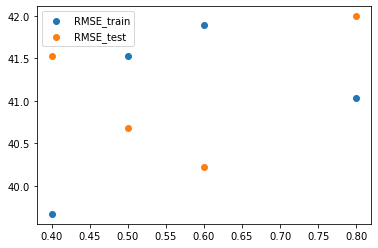

In [11]:
plt.figure()
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize, label="RMSE_train")
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize_test, label="RMSE_test")
plt.legend()

In [12]:
train_size = int(len(dataset) * 0.4)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]
seq_size = 4
trainX, trainY = to_XY(train)
testX, testY = to_XY(test)
for x in range(len(num_layers)):
    for y in range(len(activation_fun)):
        model = get_model(num_layers[x], activation_fun[y])
        trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
        RMSE_matrix_train[x, y] = trainScore
        RMSE_matrix_test[x, y] = testScore
        if(testScore<RMSE_min_test):
            RMSE_min_train = trainScore
            RMSE_min_test = testScore
            final_layers = num_layers[x]
            best_model = model

print('final number of layers are {}'.format(final_layers))
final_model = best_model

trainPredict = final_model.predict(trainX)
testPredict = final_model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))

print('Final Model Train Score for taining size 50 % : {} RMSE'.format( trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))

print('Final Model Test Score for training size 50 % : {} RMSE'.format( testScore))


plt.figure(figsize=(30,15))
plt.scatter(np.arange(1, 375),dataset[:,3])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.scatter(np.arange(1, train_size+1), trainPredict)
plt.scatter(np.arange(train_size+1, 375), testPredict)
plt.show()

8/8 [==============================] - 0s 2ms/step
final number of layers are 4
8/8 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 50 % : 41.4251688337414 RMSE
Final Model Test Score for training size 50 % : 41.10135746362069 RMSE


In [21]:
model.summary()

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_495 (Dense)           (None, 8)                 32        
                                                                 
 dense_496 (Dense)           (None, 4)                 36        
                                                                 
 dense_497 (Dense)           (None, 2)                 10        
                                                                 
 dense_498 (Dense)           (None, 3)                 9         
                                                                 
 dense_499 (Dense)           (None, 1)                 4         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________


### Model fitting for counter current flow

In [17]:
counter_data = pd.read_excel('counter_data.xlsx', header=None)
counter_data

0   1         2           3
0    1898   5  0.197810   80.793315
1    1988   2  0.500022   89.611077
2    2310   6  0.609867   97.610817
3    2219   7  0.805489   99.603940
4     866   7  0.239932   85.566232
..    ...  ..       ...         ...
509   719  10  0.437800  190.014900
510  2471   4  0.608800   97.565400
511   765   4  0.545000  144.295800
512  2174   9  0.833300   99.834700
513  1589   3  0.874900   89.930900

[514 rows x 4 columns]

In [18]:
counter_data = counter_data[counter_data[3]<100]
counter_data = counter_data[counter_data[3]>0]
counter_data

0  1         2          3
0    1898  5  0.197810  80.793315
1    1988  2  0.500022  89.611077
2    2310  6  0.609867  97.610817
3    2219  7  0.805489  99.603940
4     866  7  0.239932  85.566232
..    ... ..       ...        ...
506  1453  5  0.911900  80.621800
508   619  6  0.658000  92.230600
510  2471  4  0.608800  97.565400
512  2174  9  0.833300  99.834700
513  1589  3  0.874900  89.930900

[450 rows x 4 columns]

In [19]:
index = np.arange(1, counter_data.shape[0]+1)
counter_data.set_index(pd.Series(index), inplace=True)
counter_data

0  1         2          3
1    1898  5  0.197810  80.793315
2    1988  2  0.500022  89.611077
3    2310  6  0.609867  97.610817
4    2219  7  0.805489  99.603940
5     866  7  0.239932  85.566232
..    ... ..       ...        ...
446  1453  5  0.911900  80.621800
447   619  6  0.658000  92.230600
448  2471  4  0.608800  97.565400
449  2174  9  0.833300  99.834700
450  1589  3  0.874900  89.930900

[450 rows x 4 columns]

In [20]:
counter_data = counter_data.to_numpy()
counter_data

array([[1.89800000e+03, 5.00000000e+00, 1.97809827e-01, 8.07933146e+01],
       [1.98800000e+03, 2.00000000e+00, 5.00022436e-01, 8.96110767e+01],
       [2.31000000e+03, 6.00000000e+00, 6.09866648e-01, 9.76108175e+01],
       ...,
       [2.47100000e+03, 4.00000000e+00, 6.08800000e-01, 9.75654000e+01],
       [2.17400000e+03, 9.00000000e+00, 8.33300000e-01, 9.98347000e+01],
       [1.58900000e+03, 3.00000000e+00, 8.74900000e-01, 8.99309000e+01]])

In [22]:
num_layers = np.random.randint(1, high = 5, size = 5)
activation_fun = ['relu', 'sigmoid', 'softmax', 'tanh', 'swish']
RMSE_matrix_train = np.zeros((len(num_layers), len(activation_fun)))
RMSE_matrix_test = np.zeros((len(num_layers), len(activation_fun)))
RMSE_min_train = 10000.0
RMSE_min_test = 10000.0
final_layers = 0
best_model = []
RMSE_trainsize = []
RMSE_trainsize_test = []
for i in [0.4, 0.5, 0.6, 0.8]:
    train_size = int(len(counter_data) * i)
    test_size = len(counter_data) - train_size
    train, test = counter_data[0:train_size,:], counter_data[train_size:len(counter_data), :]
    seq_size = 4
    trainX, trainY = to_XY(train)
    testX, testY = to_XY(test)
    for x in range(len(num_layers)):
        for y in range(len(activation_fun)):
            model = get_model(num_layers[x], activation_fun[y])
            trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
            RMSE_matrix_train[x, y] = trainScore
            RMSE_matrix_test[x, y] = testScore
            if(testScore<RMSE_min_test):
                RMSE_min_train = trainScore
                RMSE_min_test = testScore
                final_layers = num_layers[x]
                best_model = model

    print('final number of layers are {}'.format(final_layers))
    final_model = best_model

    trainPredict = final_model.predict(trainX)
    testPredict = final_model.predict(testX)

    trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
    RMSE_trainsize.append(trainScore)
    print('Final Model Train Score for taining size {} % : {} RMSE'.format(i, trainScore))
    testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
    RMSE_trainsize_test.append(testScore)
    print('Final Model Test Score for training size {} % : {} RMSE'.format(i, testScore))

9/9 [==============================] - 0s 2ms/step
final number of layers are 4
9/9 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.4 % : 26.693682161664736 RMSE
Final Model Test Score for training size 0.4 % : 27.730152859446658 RMSE
8/8 [==============================] - 0s 1ms/step
final number of layers are 4
8/8 [==============================] - 0s 3ms/step
Final Model Train Score for taining size 0.5 % : 27.17664798517747 RMSE
Final Model Test Score for training size 0.5 % : 27.463168070439547 RMSE
6/6 [==============================] - 0s 3ms/step
final number of layers are 4
6/6 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 0.6 % : 27.86329230247654 RMSE
Final Model Test Score for training size 0.6 % : 27.417878386961696 RMSE
3/3 [==============================] - 0s 5ms/step
final number of layers are 4
3/3 [==============================] - 0s 5ms/step
Final Model Train Score for taining size

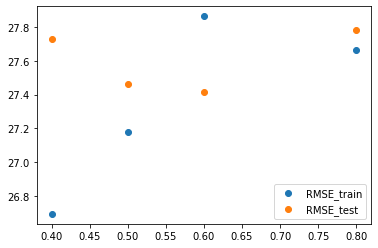

In [23]:
plt.figure()
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize, label="RMSE_train")
plt.scatter([0.4, 0.5, 0.6, 0.8], RMSE_trainsize_test, label="RMSE_test")
plt.legend()

8/8 [==============================] - 0s 3ms/step
final number of layers are 4
8/8 [==============================] - 0s 2ms/step
Final Model Train Score for taining size 50 % : 52.183852836228745 RMSE
Final Model Test Score for training size 50 % : 58.09455834209849 RMSE


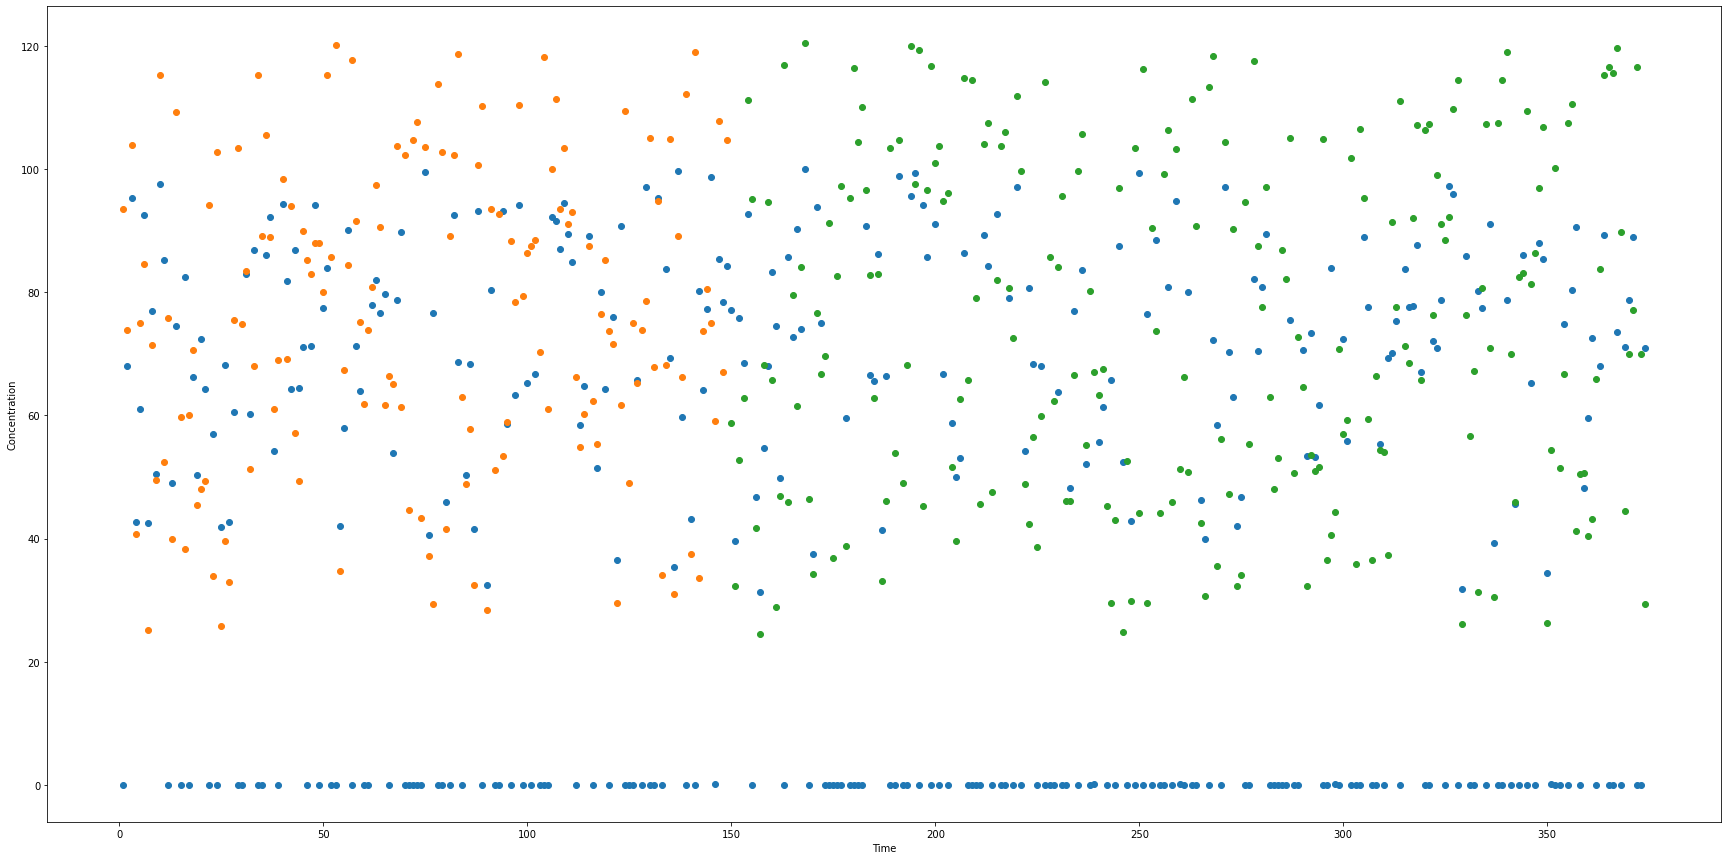

In [24]:
train_size = int(len(dataset) * 0.4)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset), :]
seq_size = 4
trainX, trainY = to_XY(train)
testX, testY = to_XY(test)
for x in range(len(num_layers)):
    for y in range(len(activation_fun)):
        model = get_model(num_layers[x], activation_fun[y])
        trainScore, testScore = evaluate_model(model, trainX, trainY, testX, testY)
        RMSE_matrix_train[x, y] = trainScore
        RMSE_matrix_test[x, y] = testScore
        if(testScore<RMSE_min_test):
            RMSE_min_train = trainScore
            RMSE_min_test = testScore
            final_layers = num_layers[x]
            best_model = model

print('final number of layers are {}'.format(final_layers))
final_model = best_model

trainPredict = final_model.predict(trainX)
testPredict = final_model.predict(testX)
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))

print('Final Model Train Score for taining size 50 % : {} RMSE'.format( trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))

print('Final Model Test Score for training size 50 % : {} RMSE'.format( testScore))


plt.figure(figsize=(30,15))
plt.scatter(np.arange(1, 375),dataset[:,3])
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.scatter(np.arange(1, train_size+1), trainPredict)
plt.scatter(np.arange(train_size+1, 375), testPredict)
plt.show()

In [25]:
model.summary()

Model: "sequential_249"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1020 (Dense)          (None, 5)                 20        
                                                                 
 dense_1021 (Dense)          (None, 9)                 54        
                                                                 
 dense_1022 (Dense)          (None, 6)                 60        
                                                                 
 dense_1023 (Dense)          (None, 2)                 14        
                                                                 
 dense_1024 (Dense)          (None, 1)                 3         
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________
